In [76]:
include("../../src/UniversalDiffEq.jl")

Main.UniversalDiffEq

# Using Hierarachical UDEs to model ecological time series

## Model structure 

Many time series of ecological data have short durations, which can limit their usefulness for reconstructing the dynamics of the assocated ecosystems. However, many monitorng programs include replicate time series at neighboring sites which may have similar dynamics. Leveraging data from multiple sites may improve the our abiltiy to learn about ecosystem dynamcis even when time series duration is limited. 

One challenge of using data from multiple sites is that the dynamcis may be slightly different, and, therefore, it might not be apropreate to fit a single model to data from each locations. Ideally, we would like to fit unique models to each location while sharing informaton between them, which can be achieved through hierarchical models. 

Hierarchical models simultaniously fit individuals models to each time series with in a group and a model representing the average of the group. Because the paramters for the individuals and group level models are estimated simultaniously the group level agerage and the individual level models have a mutual influence that can increase he precision of the individuals level models.

We can build hierarchical models using the `UniversalDiffEq.jl` library.  The library provides functions that build a unique model for each unique time series in a data set along this a model with the same structure that represents the average accross all models: 

|Data wide mean  |
|---------------|
|model 1, model 2, model 3, ...,  model n|

Additional levels can be added by specificy groups of time series with in the data set. The package will build model for each individual time series, models representingn the mena for each group, and a model representing the mena accross groups.


|    |Data wide mean  |          |
|----|----------------|---------------|
|Group 1 | Group 2 | Group 3|
|model 1, model 2, ... | model 1, model 2, ... |model 1, model 2, ... |

This sturcture allows information from all time series to be shared accross models, with most informaiton shared within groups. 


## Example: Coral - Macro algae competition

To ilustrate how the code fro these models work WE will build a model to fit a data set simulated from hte Mumby-Hastings coral - macro algea comptition model. The data set has eight simulated time series with diffent initial abundances and slightly different macro algea grazing rates. They are further divided into two groups one group has higher marconalgea growth and one with lower mocro algea growth. 

In [1]:
using CSV, DataFrames, Plots
data = CSV.read("Mumby_Hastings_sim_data.csv",DataFrame)
data[1:6,2:end]

Row,series,t,algae,coral
,Int64,Int64,Float64,Float64
1,1,1,0.106403,0.83766
2,1,2,0.0937447,0.828643
3,1,3,0.0819797,0.795294
4,1,4,0.0819508,0.784575
5,1,5,0.0794749,0.779524
6,1,6,0.0756903,0.748521


The data formatting is important. The model building functions expect the first columns of the data set to contain the group labels for each time series, followed by the series label, a colunm labed t with the time of each measurement and then the state variables. The time seris should also be sorted so all observaitosn from each time series apears consecutively in chronological order. In this case the data set has a single grouping variable, but more can be added using the left most columns.

Plotting the time series from each data set shows that the long term outcomes are primarily deterined by the starting point. When one species starts out rare, they tend two wards zero while the other dominates.  

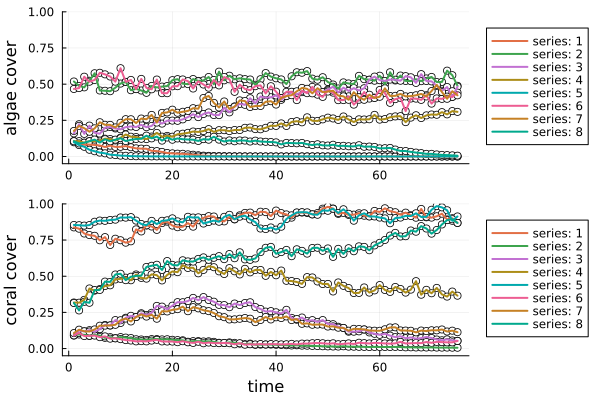

In [78]:
p1=Plots.scatter(data.t, data.algae, color = "white", label = "", ylims = (-0.05,1), ylabel = "algae cover")
p2=Plots.scatter(data.t, data.coral, color = "white", label = "", ylims = (-0.05,1), ylabel = "coral cover", xlabel = "time")
for s in unique(data.series)
    Plots.plot!(p1,data.t[data.series .== s], data.algae[data.series .== s], width = 2.0, label = string("series: ",s), legendposition = :outerright)
    Plots.plot!(p2,data.t[data.series .== s], data.coral[data.series .== s], width = 2.0,label = string("series: ",s), legendposition = :outerright)
end 
plot(p1,p2,layout = (2,1))

## Step 1: Initialize the model

`UniversalDiffEq.jl` has functions that construct models from a data set and a minimal level of user inputs. The following block of code builds a NODE model for the coral data. I use the `HierarchicalNODESimplex` function to build a model that consturcts a NODE model data that describe the proportion of area covered by differnt species. This function requires a data set and a vector called `level_weights`. The data set should have the form discussed above. The level weights specify how much weight is given to estimating the group level means. In this example, the model has one grouping level and then a mean function for the entier data set. The level weights vector has two entries, the first corresponds to the group level means and the second corresponds to the data set level mean. 

The other parameters are optional. If they are not passed they will take on a set of default values. 

In [79]:
level_weights = [0.5, 0.25]
model = UniversalDiffEq.HierarchicalNODESimplex(data,level_weights;hidden_units=10,NN_seed = 1,proc_weight=1.0,obs_weight=1.0,reg_weight = 10^-6)
nothing

## Step 2: train the model 

We can train the models using the `gradient_decent!` function. This function runs an optimizer that fits the model parameters to match the data. This function takes thre optional arguments, `verbos`, `step_size` and  `maxiter`. When `verbos` is `true` the vlaue of the loss funiton will be printed at each iteration to help monitor progress. The `step_size` argument controls how much the algorithm chagnes the paramter values on each iteration. smaller step sizes will lead to soler convergence, but can also produce more accurate results. finally, `maxiter` controls the number of steps taken by the optimizer. 

Not that running the follow cell does to a substntial amount of time (~ 10 mins on my machine).

In [80]:
UniversalDiffEq.gradient_decent!(model,verbos = true,step_size = 0.1, maxiter = 400)
UniversalDiffEq.gradient_decent!(model,verbos = true,step_size = 0.025, maxiter = 200)

54.717 53.679 52.761 51.778 50.862 49.929 49.04 48.227 47.418 46.598 45.868 45.123 44.382 43.685 43.005 42.328 41.665 41.018 40.389 39.763 39.151 38.547 37.952 37.372 36.796 36.23 35.674 35.127 34.587 34.058 33.538 33.023 32.517 32.021 31.53 31.048 30.576 30.109 29.651 29.199 28.754 28.317 27.887 27.463 27.046 26.636 26.232 25.834 25.442 25.057 24.678 24.304 23.936 23.575 23.218 22.868 22.522 22.182 21.848 21.518 21.194 20.874 20.56 20.25 19.945 19.645 19.349 19.058 18.771 18.489 18.211 17.937 17.668 17.402 17.141 16.884 16.63 16.38 16.134 15.892 15.653 15.418 15.186 14.958 14.734 14.512 14.295 14.08 13.869 13.66 13.455 13.253 13.055 12.86 12.672 12.483 12.289 12.108 11.923 11.746 11.568 11.396 11.223 11.054 10.889 10.725 10.566 10.406 10.248 10.094 9.942 9.792 9.645 9.499 9.357 9.215 9.077 8.94 8.806 8.673 8.542 8.412 8.286 8.161 8.038 7.917 7.797 7.679 7.563 7.448 7.336 7.225 7.116 7.008 6.902 6.797 6.694 6.593 6.494 6.4 6.318 6.21 6.118 6.02 5.932 5.838 5.752 5.66 5.577 5.49 5.406 5

In [88]:
UniversalDiffEq.gradient_decent!(model,verbos = true,step_size = 0.01, maxiter = 200)

0.014 0.042 0.016 0.022 0.029 0.024 0.017 0.015 0.018 0.021 0.02 0.018 0.015 0.015 0.016 0.017 0.017 0.016 0.015 0.015 0.015 0.016 0.016 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.014 0.015 0.015 0.015 0.015 0.014 0.014 0.014 0.015 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014

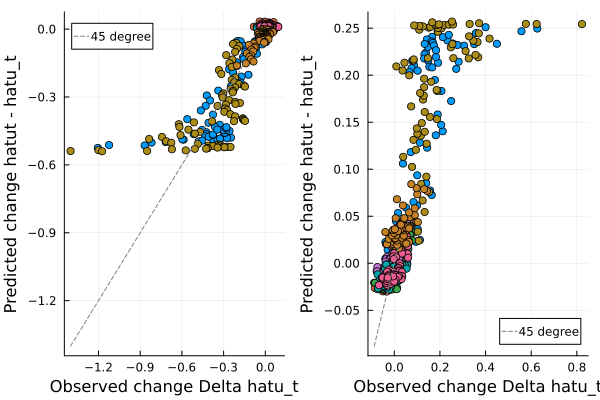

In [93]:
p1 = UniversalDiffEq.plot_predictions(model,3)
p2 = UniversalDiffEq.plot_predictions(model,2)
p3 = UniversalDiffEq.plot_predictions(model,2)

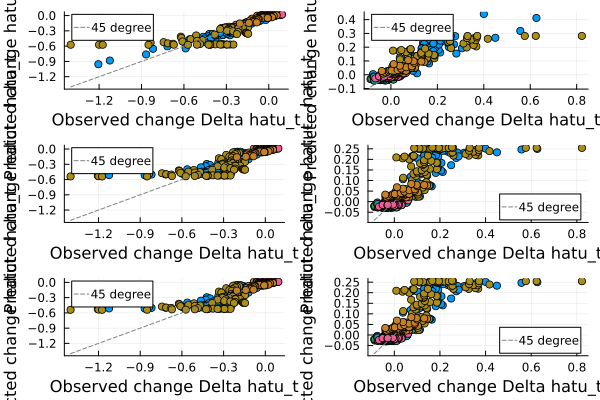

In [94]:
plot(p1,p2,p3, layout = (3,1))

2


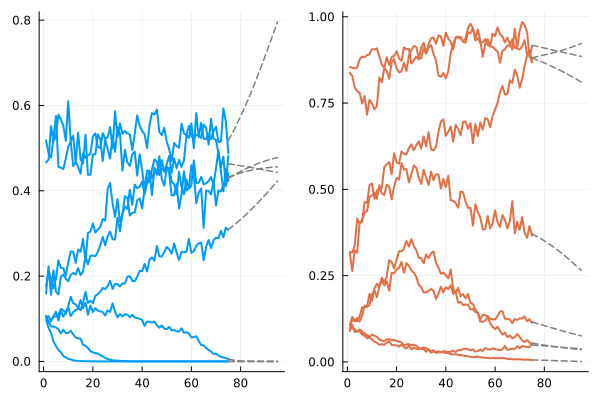

In [97]:
UniversalDiffEq.plot_forecasts(model;T=20,level_=2)


|group level 1| group level 2| ... | series | t | x1 | x2 | ...| 
|-------------|--------------|-----|--------|---|----|----|----| 
|1|1| |1| 1|x_1 |x_2| |
|1|1| |1| 2|x_1 |x_2| |
|1|1| |1| 3|x_1 |x_2| |
|1|1| |1| 4|x_1 |x_2| |
|...|...|...|...|...|...|...|...|
|1|1| |2| 1 |x_1 |x_2| |
|1|1| |2| 2|x_1 |x_2| |
|1|1| |2| 3|x_1 |x_2| |
|1|1| |2| 4|x_1 |x_2| |
|...|...|...|...|...|...|...|...|
